# Credit Card Approval - Data Processing
This notebook handles data preprocessing, feature engineering, and data preparation

**Prerequisites:** All required packages must be installed first
```bash
pip install -r requirements.txt
```

**MLflow Tracking:** All processing steps and artifacts are logged to MLflow  
**Output:** Processed data saved to `../data/processed/`

In [1]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import joblib
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [2]:
# Initialize MLflow
# End any active run first to prevent conflicts
mlflow.end_run()

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("credit_card_approval_data_processing")
mlflow.start_run(run_name="data_preprocessing")

# Create output directory
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

print("✓ MLflow experiment started")
print(f"✓ Output directory: {output_dir}")

✓ MLflow experiment started
✓ Output directory: ../data/processed


## 1. Load Raw Data

In [3]:
# Load datasets
app_data = pd.read_csv('../data/raw/application_record.csv')
credit_data = pd.read_csv('../data/raw/credit_record.csv')

print(f"📊 Application Records: {app_data.shape[0]:,} rows, {app_data.shape[1]} columns")
print(f"📊 Credit Records: {credit_data.shape[0]:,} rows, {credit_data.shape[1]} columns")

mlflow.log_param("raw_app_records", app_data.shape[0])
mlflow.log_param("raw_credit_records", credit_data.shape[0])

📊 Application Records: 438,557 rows, 18 columns
📊 Credit Records: 1,048,575 rows, 3 columns


1048575

## 2. Create Target Variable

In [4]:
# Create Good/Bad labels from STATUS
# Status 2,3,4,5 = Bad (overdue more than 60 days), 0,X,C = Good
credit_data['Good or Bad'] = credit_data['STATUS'].apply(
    lambda x: 'Good' if x in ['0', 'X', 'C'] else 'Bad'
)

# Group by ID and get dominant label
credit_goods_bads = credit_data.groupby(['ID', 'Good or Bad']).size().to_frame('size')
credit_goods_bads.reset_index(inplace=True)

idx = credit_goods_bads.groupby('ID')['size'].idxmax()
max_goods_bads = credit_goods_bads.loc[idx]

# Convert to binary (1=Good, 0=Bad)
max_goods_bads['Label'] = max_goods_bads['Good or Bad'].apply(lambda x: 1 if x == 'Good' else 0)
max_goods_bads = max_goods_bads[['ID', 'Label']].reset_index(drop=True)

print(f"✓ Created target labels for {len(max_goods_bads):,} customers")
print(f"\nLabel Distribution:")
print(f"  Good (1): {(max_goods_bads['Label'] == 1).sum():,} ({(max_goods_bads['Label'] == 1).sum() / len(max_goods_bads) * 100:.1f}%)")
print(f"  Bad (0):  {(max_goods_bads['Label'] == 0).sum():,} ({(max_goods_bads['Label'] == 0).sum() / len(max_goods_bads) * 100:.1f}%)")

mlflow.log_metric("original_good_count", (max_goods_bads['Label'] == 1).sum())
mlflow.log_metric("original_bad_count", (max_goods_bads['Label'] == 0).sum())

✓ Created target labels for 45,985 customers

Label Distribution:
  Good (1): 45,800 (99.6%)
  Bad (0):  185 (0.4%)


## 3. Merge Data & Handle Missing Values

In [5]:
# Fill missing occupation
app_data.fillna('Unknown', inplace=True)

# Merge application and credit data
data = pd.merge(app_data, max_goods_bads, how='inner', on='ID')

print(f"✓ Merged dataset: {len(data):,} rows, {data.shape[1]} columns")
print(f"\nTarget Distribution After Merge:")
print(f"  Good (1): {(data['Label'] == 1).sum():,} ({(data['Label'] == 1).sum() / len(data) * 100:.2f}%)")
print(f"  Bad (0):  {(data['Label'] == 0).sum():,} ({(data['Label'] == 0).sum() / len(data) * 100:.2f}%)")
print(f"  Imbalance Ratio: {(data['Label'] == 1).sum() / (data['Label'] == 0).sum():.2f}:1")

mlflow.log_param("merged_records", len(data))
mlflow.log_metric("imbalance_ratio", (data['Label'] == 1).sum() / (data['Label'] == 0).sum())

✓ Merged dataset: 36,457 rows, 19 columns

Target Distribution After Merge:
  Good (1): 36,290 (99.54%)
  Bad (0):  167 (0.46%)
  Imbalance Ratio: 217.31:1


## 4. Feature Engineering

In [6]:
# Prepare features and target
X = data.drop('Label', axis=1)
y = data['Label']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")

Features shape: (36457, 18)
Target shape: (36457,)

Features: ['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']


In [7]:
# Convert categorical to numerical using one-hot encoding
print("="*80)
print("FEATURE ENCODING")
print("="*80)

X_encoded = pd.get_dummies(X, drop_first=True)

print(f"\n✓ Original features: {X.shape[1]}")
print(f"✓ Encoded features: {X_encoded.shape[1]}")
print(f"\nEncoded feature columns:")
print(list(X_encoded.columns))

mlflow.log_param("original_features", X.shape[1])
mlflow.log_param("encoded_features", X_encoded.shape[1])

FEATURE ENCODING

✓ Original features: 18
✓ Encoded features: 48

Encoded feature columns:
['ID', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'CODE_GENDER_M', 'FLAG_OWN_CAR_Y', 'FLAG_OWN_REALTY_Y', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_House / apartment', 'NAME_HOUSING_TYPE_Municipal apartment', 'NAME_HOUSING_TYPE_Office apartment', 'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents', 'OCCUPATION_TYPE_Cleaning staff', 'OCCUPATION_TYPE_Cooking staff', 'OCCUPATION_TYPE

48

In [8]:
print("="*80)
print("DATA DISTRIBUTION BEFORE RESAMPLING")
print("="*80)

print(f"\n📊 Original Data Distribution:")
print(f"  Total: {len(X_encoded):,}")
print(f"  Good (1): {(y == 1).sum():,} ({(y == 1).sum() / len(y) * 100:.2f}%)")
print(f"  Bad (0): {(y == 0).sum():,} ({(y == 0).sum() / len(y) * 100:.2f}%)")

mlflow.log_param("approach", "approach_1_style")
mlflow.log_param("original_samples", len(X_encoded))
mlflow.log_param("original_good", (y == 1).sum())
mlflow.log_param("original_bad", (y == 0).sum())

DATA DISTRIBUTION BEFORE RESAMPLING

📊 Original Data Distribution:
  Total: 36,457
  Good (1): 36,290 (99.54%)
  Bad (0): 167 (0.46%)


np.int64(167)

In [10]:
print("="*80)
print("HANDLING CLASS IMBALANCE WITH SMOTE + TOMEK")
print("="*80)

print(f"\n📊 Before Resampling:")
print(f"  Total: {len(X_encoded):,}")
print(f"  Good (1): {(y == 1).sum():,} ({(y == 1).sum() / len(y) * 100:.2f}%)")
print(f"  Bad (0): {(y == 0).sum():,} ({(y == 0).sum() / len(y) * 100:.2f}%)")

# Apply SMOTE + Tomek to balance the dataset
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_encoded, y)

print(f"\n📊 After SMOTE + Tomek:")
print(f"  Total: {len(X_resampled):,}")
print(f"  Good (1): {(y_resampled == 1).sum():,} ({(y_resampled == 1).sum() / len(y_resampled) * 100:.2f}%)")
print(f"  Bad (0): {(y_resampled == 0).sum():,} ({(y_resampled == 0).sum() / len(y_resampled) * 100:.2f}%)")
print(f"  Balance Ratio: {(y_resampled == 1).sum() / (y_resampled == 0).sum():.2f}:1")

mlflow.log_metric("resampled_total", len(X_resampled))
mlflow.log_metric("resampled_good", (y_resampled == 1).sum())
mlflow.log_metric("resampled_bad", (y_resampled == 0).sum())

HANDLING CLASS IMBALANCE WITH SMOTE + TOMEK

📊 Before Resampling:
  Total: 36,457
  Good (1): 36,290 (99.54%)
  Bad (0): 167 (0.46%)

📊 After SMOTE + Tomek:
  Total: 72,496
  Good (1): 36,248 (50.00%)
  Bad (0): 36,248 (50.00%)
  Balance Ratio: 1.00:1



✓ Figure saved to ../data/processed/smote_tomek_comparison.png


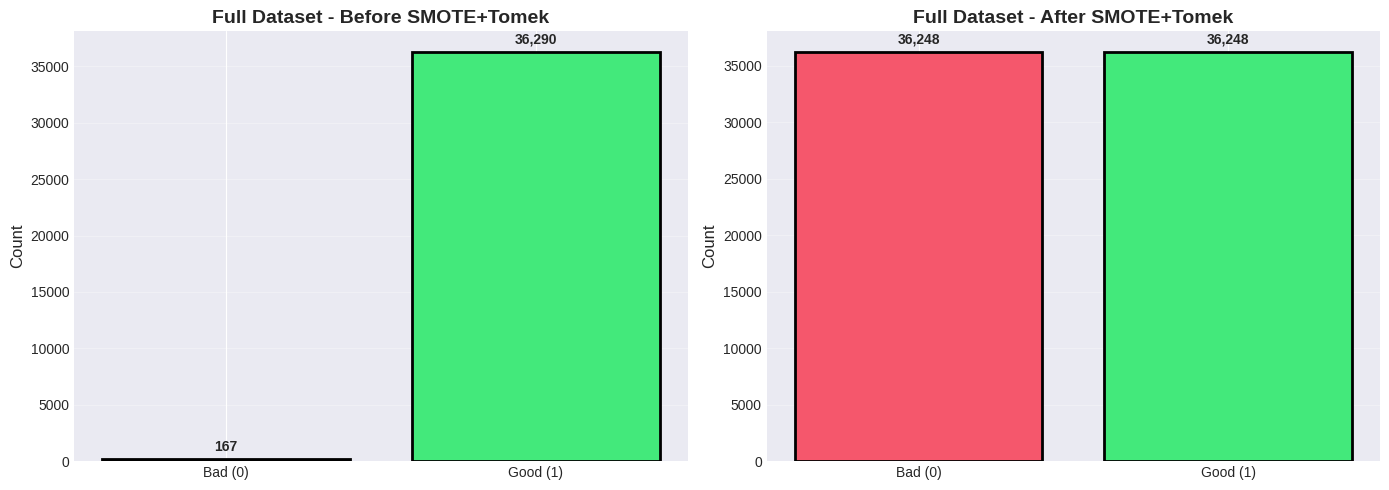

In [11]:
# Visualize before/after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before (Original data before SMOTE)
before_counts = pd.Series(y).value_counts().sort_index()
axes[0].bar(['Bad (0)', 'Good (1)'], [before_counts[0], before_counts[1]], 
            color=['#f5576c', '#43e97b'], edgecolor='black', linewidth=2)
axes[0].set_title('Full Dataset - Before SMOTE+Tomek', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(alpha=0.3, axis='y')
for i, count in enumerate([before_counts[0], before_counts[1]]):
    axes[0].text(i, count + 500, f'{count:,}', ha='center', va='bottom', fontweight='bold')

# After (Full data after SMOTE)
after_counts = pd.Series(y_resampled).value_counts().sort_index()
axes[1].bar(['Bad (0)', 'Good (1)'], [after_counts[0], after_counts[1]], 
            color=['#f5576c', '#43e97b'], edgecolor='black', linewidth=2)
axes[1].set_title('Full Dataset - After SMOTE+Tomek', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12)
axes[1].grid(alpha=0.3, axis='y')
for i, count in enumerate([after_counts[0], after_counts[1]]):
    axes[1].text(i, count + 500, f'{count:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
# Save figure locally instead of mlflow.log_figure to avoid google.cloud dependency
fig.savefig(output_dir / 'smote_tomek_comparison.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Figure saved to {output_dir / 'smote_tomek_comparison.png'}")
plt.show()

## 7. Feature Scaling

In [12]:
print("="*80)
print("FEATURE SCALING")
print("="*80)

# Fit scaler on resampled data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

print(f"\n✓ Scaler fitted on full resampled dataset")
print(f"✓ Scaled shape: {X_scaled.shape}")

# Save scaler
scaler_path = output_dir / 'scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler saved to {scaler_path}")

FEATURE SCALING

✓ Scaler fitted on full resampled dataset
✓ Scaled shape: (72496, 48)
✓ Scaler saved to ../data/processed/scaler.pkl


In [14]:
print("="*80)
print("PCA DIMENSIONALITY REDUCTION")
print("="*80)

# Fit PCA on scaled resampled data
pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Convert to DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])

print(f"\n✓ PCA fitted on full resampled dataset")
print(f"✓ PCA components: {X_pca.shape[1]}")
print(f"✓ PCA shape: {X_pca.shape}")
print(f"\n✓ Explained variance ratio:")
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    print(f"  PC{i}: {var:.4f} ({var*100:.2f}%)")
print(f"\n✓ Total variance explained: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")

mlflow.log_param("pca_components", 5)
mlflow.log_metric("pca_total_variance", pca.explained_variance_ratio_.sum())

# Save PCA
pca_path = output_dir / 'pca.pkl'
joblib.dump(pca, pca_path)
print(f"✓ PCA saved to {pca_path}")

PCA DIMENSIONALITY REDUCTION

✓ PCA fitted on full resampled dataset
✓ PCA components: 5
✓ PCA shape: (72496, 5)

✓ Explained variance ratio:
  PC1: 0.0895 (8.95%)
  PC2: 0.0522 (5.22%)
  PC3: 0.0471 (4.71%)
  PC4: 0.0426 (4.26%)
  PC5: 0.0373 (3.73%)

✓ Total variance explained: 0.2686 (26.86%)
✓ PCA saved to ../data/processed/pca.pkl



✓ Figure saved to ../data/processed/pca_variance_explained.png


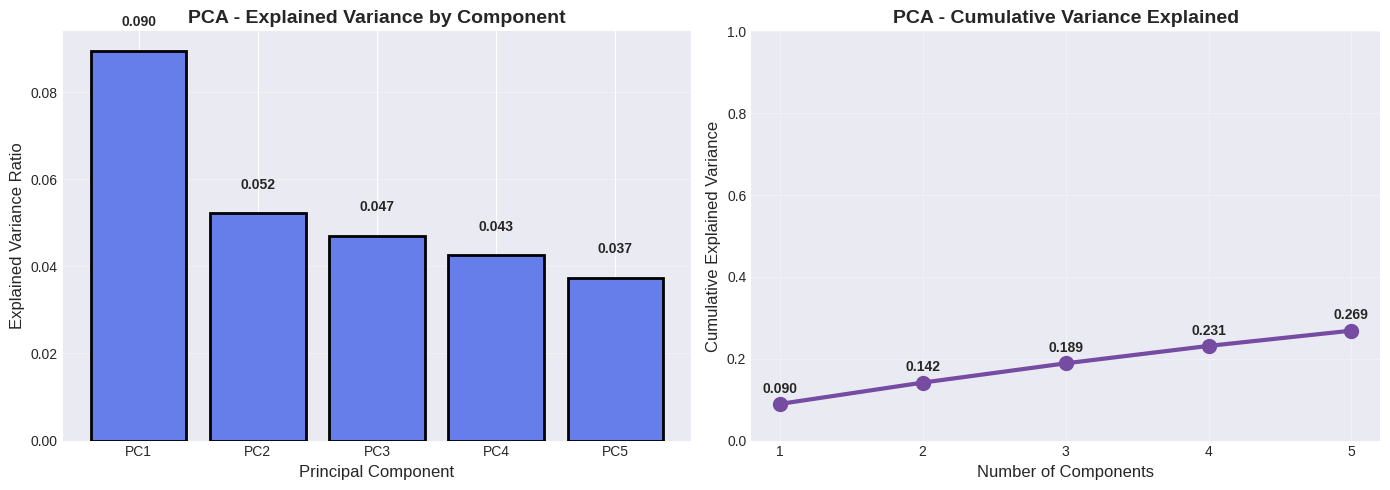

In [15]:
# Visualize PCA explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual variance
axes[0].bar(range(1, 6), pca.explained_variance_ratio_, color='#667eea', edgecolor='black', linewidth=2)
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('PCA - Explained Variance by Component', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(1, 6))
axes[0].set_xticklabels([f'PC{i}' for i in range(1, 6)])
axes[0].grid(alpha=0.3, axis='y')
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    axes[0].text(i, var + 0.005, f'{var:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Cumulative variance
cumulative_var = np.cumsum(pca.explained_variance_ratio_)
axes[1].plot(range(1, 6), cumulative_var, marker='o', color='#764ba2', linewidth=3, markersize=10)
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('PCA - Cumulative Variance Explained', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(1, 6))
axes[1].grid(alpha=0.3)
axes[1].set_ylim([0, 1])
for i, var in enumerate(cumulative_var, 1):
    axes[1].text(i, var + 0.02, f'{var:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
# Save locally instead of mlflow.log_figure
fig.savefig(output_dir / 'pca_variance_explained.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Figure saved to {output_dir / 'pca_variance_explained.png'}")
plt.show()

## 9. Train-Test Split

In [16]:
print("="*80)
print("TRAIN-TEST SPLIT")
print("="*80)

# Split the resampled and PCA-transformed data
X_train_pca, X_test_pca, y_train, y_test = train_test_split(
    X_pca_df, y_resampled, test_size=0.2, random_state=42
)

print(f"\n📊 Data Split:")
print(f"  Training: {X_train_pca.shape[0]:,} samples")
print(f"    - Good (1): {(y_train == 1).sum():,} ({(y_train == 1).sum() / len(y_train) * 100:.2f}%)")
print(f"    - Bad (0): {(y_train == 0).sum():,} ({(y_train == 0).sum() / len(y_train) * 100:.2f}%)")
print(f"  Test: {X_test_pca.shape[0]:,} samples")
print(f"    - Good (1): {(y_test == 1).sum():,} ({(y_test == 1).sum() / len(y_test) * 100:.2f}%)")
print(f"    - Bad (0): {(y_test == 0).sum():,} ({(y_test == 0).sum() / len(y_test) * 100:.2f}%)")

mlflow.log_param("test_size", 0.2)
mlflow.log_param("train_samples", X_train_pca.shape[0])
mlflow.log_param("test_samples", X_test_pca.shape[0])

TRAIN-TEST SPLIT

📊 Data Split:
  Training: 57,996 samples
    - Good (1): 29,009 (50.02%)
    - Bad (0): 28,987 (49.98%)
  Test: 14,500 samples
    - Good (1): 7,239 (49.92%)
    - Bad (0): 7,261 (50.08%)


14500

In [17]:
print("="*80)
print("SAVING PROCESSED DATA")
print("="*80)

# Save PCA-transformed data
X_train_pca.to_csv(output_dir / 'X_train.csv', index=False)
X_test_pca.to_csv(output_dir / 'X_test.csv', index=False)
pd.DataFrame(y_train, columns=['Label']).to_csv(output_dir / 'y_train.csv', index=False)
pd.DataFrame(y_test, columns=['Label']).to_csv(output_dir / 'y_test.csv', index=False)

print(f"\n✓ Saved to {output_dir}:")
print(f"  - X_train.csv ({X_train_pca.shape[0]} x {X_train_pca.shape[1]})")
print(f"  - X_test.csv ({X_test_pca.shape[0]} x {X_test_pca.shape[1]})")
print(f"  - y_train.csv ({len(y_train)} samples)")
print(f"  - y_test.csv ({len(y_test)} samples)")
print(f"  - scaler.pkl")
print(f"  - pca.pkl")

SAVING PROCESSED DATA

✓ Saved to ../data/processed:
  - X_train.csv (57996 x 5)
  - X_test.csv (14500 x 5)
  - y_train.csv (57996 samples)
  - y_test.csv (14500 samples)
  - scaler.pkl
  - pca.pkl


## 10. Save Processed Data

In [18]:
print("="*80)
print("DATA PROCESSING SUMMARY")
print("="*80)

summary = f"""
DATA PROCESSING PIPELINE COMPLETED

Input:
  - Application Records: {app_data.shape[0]:,}
  - Credit Records: {credit_data.shape[0]:,}
  
Processing Steps:
  1. Target Creation: Good/Bad labels based on credit status
  2. Data Merging: {len(data):,} records after merge
  3. Missing Values: Filled with 'Unknown'
  4. Feature Encoding: {X.shape[1]} → {X_encoded.shape[1]} features (one-hot encoding)
  5. SMOTE+Tomek: {len(X_encoded):,} → {len(X_resampled):,} samples
  6. Feature Scaling: StandardScaler fitted
  7. PCA: {X_resampled.shape[1]} → {X_pca.shape[1]} components ({pca.explained_variance_ratio_.sum()*100:.2f}% variance)
  8. Train-Test Split: {X_train_pca.shape[0]:,} / {X_test_pca.shape[0]:,} (80/20)

Output:
  - Training Set: {X_train_pca.shape[0]:,} samples
  - Test Set: {X_test_pca.shape[0]:,} samples
  - Preprocessors saved: scaler.pkl, pca.pkl
  - All data saved to: {output_dir}

✅ Data is ready for model training!
"""

print(summary)
mlflow.log_text(summary, "processing_summary.txt")

# End MLflow run
mlflow.end_run()
print("\n✅ Data processing completed and logged to MLflow")

DATA PROCESSING SUMMARY

DATA PROCESSING PIPELINE COMPLETED

Input:
  - Application Records: 438,557
  - Credit Records: 1,048,575
  
Processing Steps:
  1. Target Creation: Good/Bad labels based on credit status
  2. Data Merging: 36,457 records after merge
  3. Missing Values: Filled with 'Unknown'
  4. Feature Encoding: 18 → 48 features (one-hot encoding)
  5. SMOTE+Tomek: 36,457 → 72,496 samples
  6. Feature Scaling: StandardScaler fitted
  7. PCA: 48 → 5 components (26.86% variance)
  8. Train-Test Split: 57,996 / 14,500 (80/20)

Output:
  - Training Set: 57,996 samples
  - Test Set: 14,500 samples
  - Preprocessors saved: scaler.pkl, pca.pkl
  - All data saved to: ../data/processed

✅ Data is ready for model training!

🏃 View run data_preprocessing at: http://127.0.0.1:5000/#/experiments/2/runs/5d7da2594a764e3d9eb6effcaeb16926
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2

✅ Data processing completed and logged to MLflow
